In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()

## Pretraitement

In [13]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)

In [14]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112176 entries, 0 to 112185
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_year_id          112176 non-null  int64         
 1   ranking               112176 non-null  float64       
 2   runner                112176 non-null  object        
 3   time                  112176 non-null  object        
 4   age                   112176 non-null  float64       
 5   gender                112176 non-null  object        
 6   nationality           112176 non-null  object        
 7   time_in_seconds       112176 non-null  float64       
 8   runner_id             112176 non-null  object        
 9   age_course            112176 non-null  float64       
 10  age_range             112176 non-null  category      
 11  speed                 112176 non-null  float64       
 12  equivalent_speed      112176 non-null  float64       
 13 

## Prédiction de performance pour les coureurs en 2019

In [15]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    date_to_predict = race_to_predict.iloc[0]['date']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    country_to_predict = race_to_predict.iloc[0]['country_code']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        total_races = 0
        avg_relative_rank = 1
        avg_rank = 10000
        max_relative_rank = 1
        min_relative_rank = 1
        
        total_elevation = 0
        avg_elevation = 0
        
        total_distance = 0
        avg_distance = 0
        min_distance = 0
        max_distance = 0
        
        total_eq_distance = 0
        avg_eq_distance = 0
        min_eq_distance = 0
        max_eq_distance = 0
        
        avg_runners = 0
        
        years_of_activity = race_to_predict.year
        last_year_activity = race_to_predict.year
        
        
        
        
        has_run = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        avg_speed = 0
        last_course_speed = 0
        home_country = 0
        avg_speed = 0
        avg_equivalent_speed = 0
        
        if nationality == country_to_predict:
            home_country = 1
        
        if runner_past.size >= 1: 
            has_run = 1
            total_races = runner_past.shape[0]
            
            avg_relative_rank = runner_past.relative_ranking.mean()
            avg_rank = runner_past.ranking.mean()
            max_relative_rank = runner_past.relative_ranking.max()
            min_relative_rank = runner_past.relative_ranking.min()
            
            total_elevation = runner_past.elevation_gain.sum()
            avg_elevation = runner_past.elevation_gain.mean()
            
            total_distance =  runner_past.distance.sum()
            avg_distance = runner_past.distance.mean()
            min_distance = runner_past.distance.min()
            max_distance = runner_past.distance.max()
            
            total_eq_distance = runner_past.equivalent_distance.sum()
            avg_eq_distance = runner_past.equivalent_distance.mean()
            min_eq_distance = runner_past.equivalent_distance.min()
            max_eq_distance = runner_past.equivalent_distance.max()
            
            avg_runners = runner_past.frequency_in_ranking.mean()

            avg_speed = runner_past.equivalent_speed.mean()
            last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']
            
            years_of_activity = race_to_predict.year - runner_past.year.min()
            
            last_year_activity = runner_past.year.max()
            
            
            avg_speed = runner_past.speed.mean()
            avg_equivalent_speed = runner_past.equivalent_speed.mean()
            
            
#             for i in range(len(runner_past)):
#                 ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'n_races': total_races,
                        'avg_relative_rank': avg_relative_rank,
                        'avg_rank': avg_rank,
                        'max_relative_rank' : max_relative_rank,
                        'min_relative_rank' : min_relative_rank,
                        'total_elevation' : total_elevation,
                        'avg_elevation' : avg_elevation,
                        'total_distance' : total_distance,
                        'avg_distance' : avg_distance,
                        'min_distance' : min_distance,
                        'max_distance' : max_distance,
                        'total_eq_distance' : total_eq_distance,
                        'avg_eq_distance' : avg_eq_distance,
                        'min_eq_distance' : min_eq_distance,
                        'max_eq_distance' : max_eq_distance,
                        'avg_runners' : avg_runners,
                        'years_of_activity': years_of_activity,
                        'last_year_activity': last_year_activity,
                        'avg_speed': avg_speed,
                        'avg_equivalent_speed': avg_equivalent_speed,
                        
                        'total_distance': total_distance,
#                         'distance_previous_year': distance_previous_year,
                        'has_run': has_run,
#                         'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year,
#                         'ranking_score': ranking_score,
                        'avg_speed': avg_speed,
                        'last_course_speed': last_course_speed,
                        'home_country': home_country
                       }, ignore_index = True)
        
        
    values_to_predict = join.loc[join.race_year_id == race_year_id_to_predict][['runner_id','ranking','relative_ranking','time_in_seconds']]
    values_to_predict = values_to_predict.drop_duplicates(subset=['runner_id'], keep='last')
    values_to_predict = values_to_predict.reset_index()
    
    one_hot_gender = pd.get_dummies(df['gender'], prefix = "gender")
    one_hot_nationality= pd.get_dummies(df['nationality'], prefix = "nat")
    # Drop column B as it is now encoded
    df = df.drop('gender',axis = 1)
    df = df.drop('nationality',axis = 1)
    # Join the encoded df
    df = df.join(one_hot_gender)
    df = df.join(one_hot_nationality)
    
    return df, values_to_predict

In [16]:
runner_p, dz = runner_profile(join,race, 39881)

100%|██████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:32<00:00, 47.36it/s]


In [17]:
runner_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557 entries, 0 to 1556
Data columns (total 92 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   runner_id                  1557 non-null   object 
 1   age                        1557 non-null   float64
 2   n_races                    1557 non-null   float64
 3   avg_relative_rank          1557 non-null   float64
 4   avg_rank                   1557 non-null   float64
 5   max_relative_rank          1557 non-null   float64
 6   min_relative_rank          1557 non-null   float64
 7   total_elevation            1557 non-null   float64
 8   avg_elevation              1557 non-null   float64
 9   total_distance             1557 non-null   float64
 10  avg_distance               1557 non-null   float64
 11  min_distance               1557 non-null   float64
 12  max_distance               1557 non-null   float64
 13  total_eq_distance          1557 non-null   float

In [42]:
runner_p.avg_runners

0       1412.666667
1       1438.333333
2       2062.500000
3          0.000000
4       2542.000000
           ...     
1552     790.000000
1553       0.000000
1554    1824.000000
1555    1832.750000
1556       0.000000
Name: avg_runners, Length: 1557, dtype: float64

<AxesSubplot:>

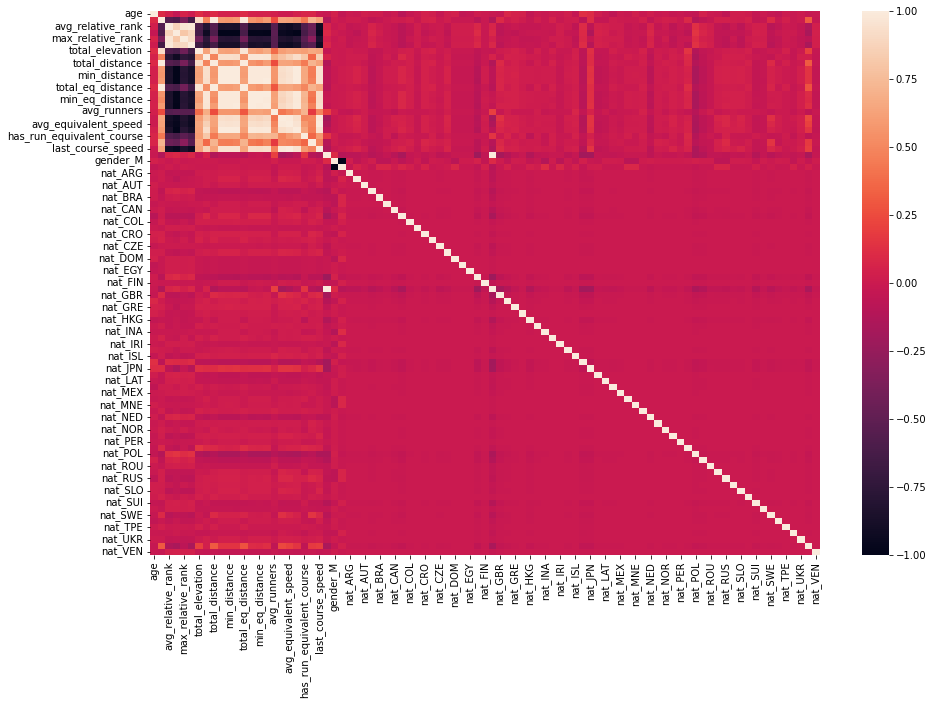

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(runner_p.corr(), annot=False)

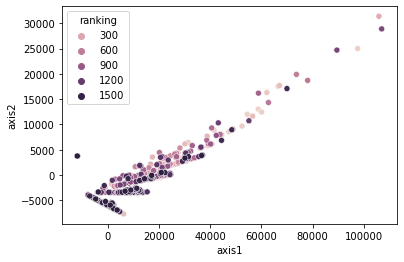

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = runner_p.drop(columns=['runner_id'])



cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['ranking'] = dz.ranking
X['relative_ranking'] = dz.relative_ranking

sns.scatterplot(x = "axis1", y = "axis2", hue="ranking",data = X)
plt.savefig('test1.pdf')


In [20]:
cls.explained_variance_ratio_

array([8.97455116e-01, 9.33796237e-02, 7.92228143e-03, 1.18078556e-03,
       5.45257618e-05])

In [21]:
cls.components_

array([[ 5.34780188e-05,  1.18256130e-04, -1.58302122e-05,
        -2.28731664e-01, -1.17660262e-05, -1.88860401e-05,
         9.48371630e-01,  2.10091385e-01,  1.95022837e-02,
         3.89824706e-03,  3.79658857e-03,  3.99483509e-03,
         2.89860000e-02,  5.99916091e-03,  5.62057032e-03,
         6.38513426e-03,  2.26413268e-02, -4.74079496e-02,
        -2.74338186e-05,  1.16737539e-04,  1.77047239e-04,
         2.35336507e-05,  2.08197528e-05,  3.58694523e-05,
         1.78324189e-04, -1.06559901e-06,  6.35512677e-08,
        -6.35512677e-08,  9.65438992e-08,  1.74035585e-08,
        -1.64428780e-08, -4.86087046e-07, -2.36173243e-07,
        -4.86551071e-09, -8.19928303e-08,  4.96427678e-07,
         1.12439373e-07, -3.46592794e-08,  1.71378634e-07,
         9.67331496e-08, -1.93462529e-08,  9.84776106e-08,
        -3.46592774e-08, -3.46592818e-08, -3.46592811e-08,
        -1.12772264e-06, -1.20839645e-07, -1.06559901e-06,
         2.44466039e-07,  2.64631917e-07,  2.13873605e-0

<AxesSubplot:xlabel='time_in_seconds', ylabel='Count'>

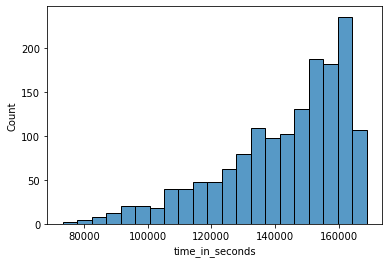

In [22]:
sns.histplot(x = dz.time_in_seconds)

# Test d'apprentissage KPPV

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as linalg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.linalg as linalg
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [24]:
Z = dz
X = runner_p.drop(columns=['runner_id'])

In [25]:
def model_efficiency(X,Z):
    res = []
    param_grid ={
        'n_neighbors' : [a for a in range(2,50)]
    }
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, param_grid)

    for q in tqdm(np.arange(0.05,1,0.05)):
#         time_TH = Z.time_in_seconds.quantile(q)
#         Z = Z.assign( flag = Z.time_in_seconds > time_TH )
#         y = Z['flag'].astype(int)
#         df['quantile'] = pd.qcut(df['b'], 2, labels=False)
        
        y = pd.qcut(Z['time_in_seconds'], 2, labels=False)
       
        
        res_GS = clf.fit(X,y)

        ### PLOT PARAM test_score
        #sns.lineplot(
        #    x ='param_n_neighbors', 
        #    y = 'mean_test_score', 
        #    data = res_GS.cv_results_
        #)
        cls = KNeighborsClassifier(n_neighbors=res_GS.best_params_['n_neighbors'])
        cls.fit(X,y)
        labels = cls.predict(X)
    
    
        res.append((q,accuracy_score(y, labels)))
    return res

In [26]:
def model_efficiency2(X,Z):
    res = []
    param_grid ={
        'n_neighbors' : [a for a in range(2,50)]
    }
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, param_grid)

    y = pd.qcut(Z['time_in_seconds'], 10, labels=False)


    res_GS = clf.fit(X,y)

    ## PLOT PARAM test_score
    sns.lineplot(
       x ='param_n_neighbors', 
       y = 'mean_test_score', 
       data = res_GS.cv_results_
    )
    
    cls = KNeighborsClassifier(n_neighbors=res_GS.best_params_['n_neighbors'])
    cls.fit(X,y)
    labels = cls.predict(X)


    return accuracy_score(y, labels), labels


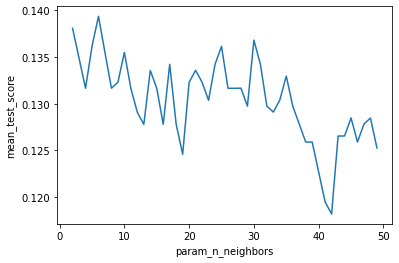

In [27]:
res, labels = model_efficiency2(X,Z)

In [28]:
res

0.35067437379576105

# Multiple Regression

In [29]:
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

In [30]:
y = Z.time_in_seconds
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
# LR = LinearRegression()
# LR = linear_model.Ridge(alpha=0.5)
# LR = linear_model.Lasso(alpha=0.1, max_iter=1000000)
# LR = linear_model.LassoLars(alpha=.1, normalize=False)
LR = ElasticNet(random_state=0, max_iter=1000000)
LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)
score=r2_score(y_test,y_prediction)
print('r2 socre is ',score)

r2 socre is  0.42659820921297387


C:\Users\pauli\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 409826511.1587219, tolerance: 41925508.281888895
  model = cd_fast.enet_coordinate_descent(


<AxesSubplot:xlabel='time_in_seconds', ylabel='Count'>

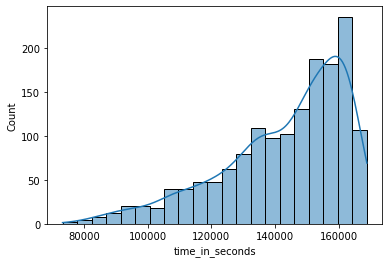

In [31]:
sns.histplot(x = dz.time_in_seconds, kde=True)

<AxesSubplot:ylabel='Count'>

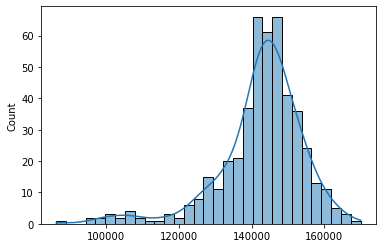

In [32]:
sns.histplot(x = y_prediction, kde=True)

In [33]:
y = pd.qcut(Z['time_in_seconds'], 10, labels=False)

In [34]:
from sklearn.model_selection import KFold, cross_val_score
def knn_cross_validation(X, y, n_folds, n_neighbors_list):
    # Générer la même sortie de `knn_cross_validation` en utilisant `cross_val_score`
    for n_neighbors in n_neighbors_list:
        cls = KNeighborsClassifier(n_neighbors=n_neighbors)
        for i in cross_val_score(cls, X, y, cv = n_folds):
            yield n_neighbors, i

<AxesSubplot:xlabel='n_neighbors', ylabel='accuracy'>

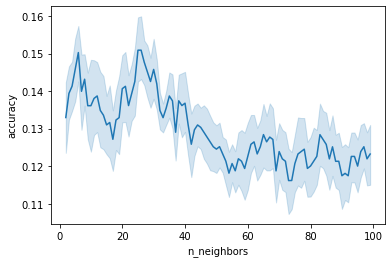

In [35]:
gen3 = knn_cross_validation(X, y,10, [i for i in range(2,100)])
df3 = pd.DataFrame(gen3, columns=["n_neighbors", "accuracy"])
sns.lineplot(
    x = 'n_neighbors',
    y = 'accuracy',
    data = df3,
    err_style="band", 
    ci=68
)

In [36]:
df3[df3.index == df3.idxmax().accuracy]

,n_neighbors,accuracy
121,14,0.211538


In [37]:
def train_model(model, prediction_function, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = prediction_function(model, X_train)
    print('train precision: ' + str(precision_score(y_train, y_train_pred)))
    print('train recall: ' + str(recall_score(y_train, y_train_pred)))
    print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))
    y_test_pred = prediction_function(model, X_test)
    print('test precision: ' + str(precision_score(y_test, y_test_pred)))
    print('test recall: ' + str(recall_score(y_test, y_test_pred)))
    print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))
    
    return model

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

y = Z.ranking
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
model = train_model(LogisticRegression(max_iter=1000), get_predicted_outcome, X_train, y_train, X_test, y_test)

C:\Users\pauli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

### Regression tree

In [39]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=44)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

[Text(444.5186331102695, 892.2727272727273, 'min_relative_rank <= 0.116\nmse = 208379.908\nsamples = 1089\nvalue = 784.206'),
 Text(97.15094453945362, 864.8181818181819, 'avg_equivalent_speed <= 7.457\nmse = 100017.528\nsamples = 182\nvalue = 309.874'),
 Text(32.16363121432617, 837.3636363636364, 'avg_runners <= 768.5\nmse = 156073.976\nsamples = 38\nvalue = 601.605'),
 Text(8.914644242080955, 809.9090909090909, 'avg_runners <= 89.2\nmse = 177553.122\nsamples = 14\nvalue = 956.857'),
 Text(3.2416888153021657, 782.4545454545455, 'avg_equivalent_speed <= 6.968\nmse = 15500.25\nsamples = 2\nvalue = 300.5'),
 Text(1.6208444076510828, 755.0, 'mse = 0.0\nsamples = 1\nvalue = 425.0'),
 Text(4.862533222953249, 755.0, 'mse = 0.0\nsamples = 1\nvalue = 176.0'),
 Text(14.587599668859745, 782.4545454545455, 'avg_course_per_year <= 1.1\nmse = 120794.354\nsamples = 12\nvalue = 1066.25'),
 Text(8.104222038255415, 755.0, 'max_eq_distance <= 243.6\nmse = 118547.139\nsamples = 6\nvalue = 835.833'),
 Text

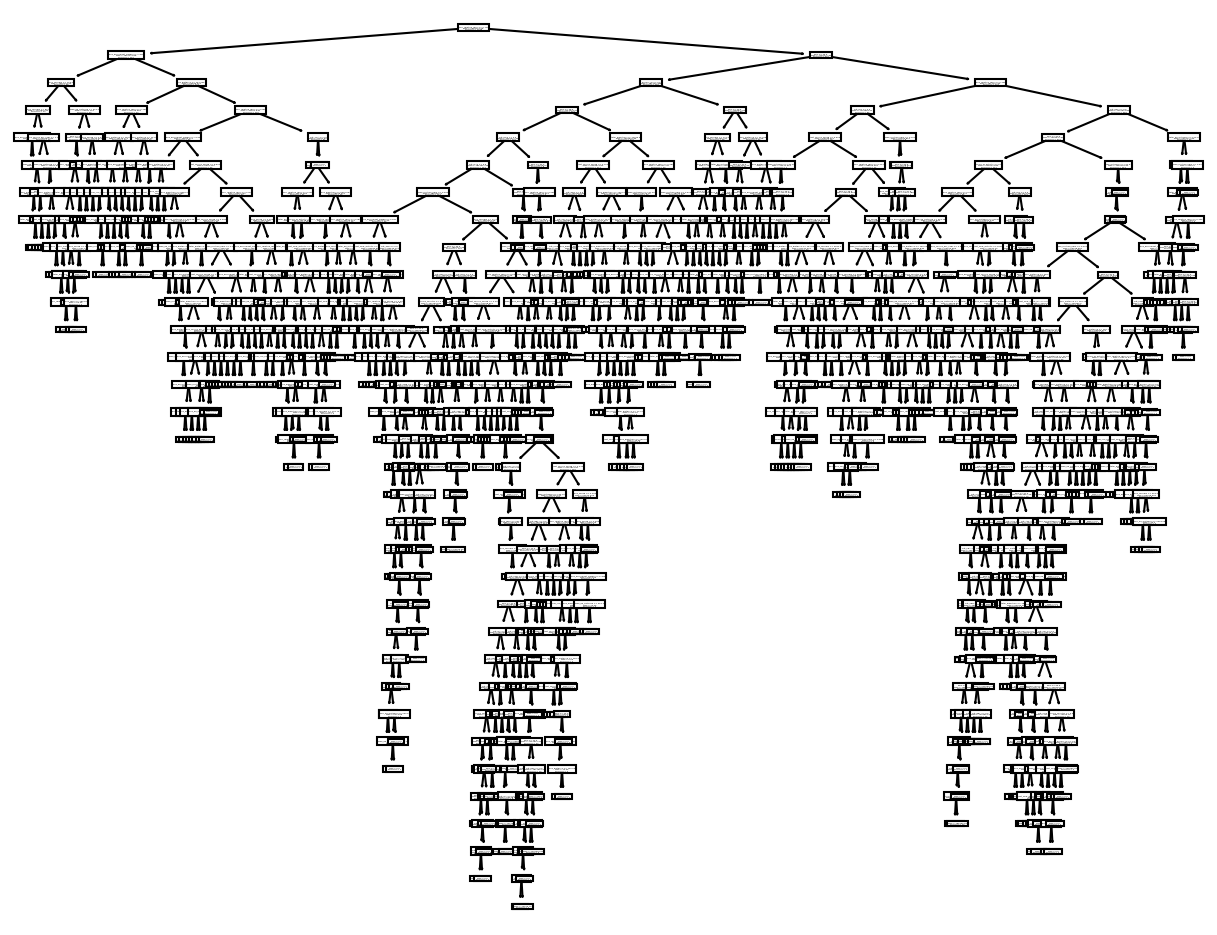

In [40]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,8), dpi=150)
plot_tree(model, feature_names=X.columns)

# Get all runners historic

In [4]:
def all_runner_profile(join):
    #Collect data from course
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_past = join.loc[(join.runner_id == runner)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_past['age'].iloc[0]
        gender = runner_past['gender'].iloc[0]
        nationality = runner_past['nationality'].iloc[0]
        
        #Processed data        
        
        total_races = runner_past.shape[0]

        avg_relative_rank = runner_past.relative_ranking.mean()
        avg_rank = runner_past.ranking.mean()
        max_relative_rank = runner_past.relative_ranking.max()
        min_relative_rank = runner_past.relative_ranking.min()

        total_elevation = runner_past.elevation_gain.sum()
        avg_elevation = runner_past.elevation_gain.mean()

        total_distance =  runner_past.distance.sum()
        avg_distance = runner_past.distance.mean()
        min_distance = runner_past.distance.min()
        max_distance = runner_past.distance.max()

        total_eq_distance = runner_past.equivalent_distance.sum()
        avg_eq_distance = runner_past.equivalent_distance.mean()
        min_eq_distance = runner_past.equivalent_distance.min()
        max_eq_distance = runner_past.equivalent_distance.max()

        avg_runners = runner_past.frequency_in_ranking.mean()

        avg_speed = runner_past.equivalent_speed.mean()
        last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']

        years_of_activity = runner_past.year.max() - runner_past.year.min()

        last_year_activity = runner_past.year.max()


        avg_speed = runner_past.speed.mean()
        avg_equivalent_speed = runner_past.equivalent_speed.mean()

        ranking_score = 0
        for i in range(len(runner_past)):
            ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

        year_interval = runner_past.year.max()- runner_past.year.min()
        avg_course_per_year = 0
        if year_interval != 0:
            avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'n_races': total_races,
                        'avg_relative_rank': avg_relative_rank,
                        'avg_rank': avg_rank,
                        'max_relative_rank' : max_relative_rank,
                        'min_relative_rank' : min_relative_rank,
                        'total_elevation' : total_elevation,
                        'avg_elevation' : avg_elevation,
                        'total_distance' : total_distance,
                        'avg_distance' : avg_distance,
                        'min_distance' : min_distance,
                        'max_distance' : max_distance,
                        'total_eq_distance' : total_eq_distance,
                        'avg_eq_distance' : avg_eq_distance,
                        'min_eq_distance' : min_eq_distance,
                        'max_eq_distance' : max_eq_distance,
                        'avg_runners' : avg_runners,
                        'years_of_activity': years_of_activity,
                        'avg_speed': avg_speed,
                        'avg_equivalent_speed': avg_equivalent_speed,
                        'total_distance': total_distance,
                        'avg_course_per_year': avg_course_per_year,
                        'ranking_score': ranking_score,
                        'avg_speed': avg_speed,
                       }, ignore_index = True)
    
    return df

In [6]:
runner_data = all_runner_profile(join)

100%|████████████████████████████████████████████████████████████████████████████| 64193/64193 [16:40<00:00, 64.14it/s]


In [305]:
from pathlib import Path  

filepath = Path('../../output/data_clean/runner_data.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

runner_data.to_csv(filepath)  

<AxesSubplot:xlabel='count', ylabel='n_races'>

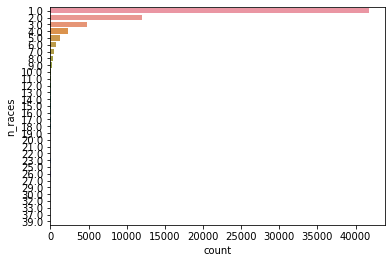

In [308]:
sns.countplot(
    y = runner_data.n_races
)

<AxesSubplot:xlabel='total_distance', ylabel='Count'>

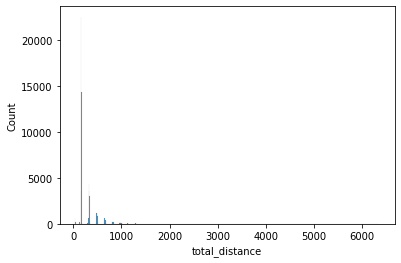

In [311]:
sns.histplot(
    x = runner_data.total_distance
)

Index(['age', 'n_races', 'avg_relative_rank', 'avg_rank', 'max_relative_rank',
       'min_relative_rank', 'total_elevation', 'avg_elevation',
       'total_distance', 'avg_distance', 'min_distance', 'max_distance',
       'total_eq_distance', 'avg_eq_distance', 'min_eq_distance',
       'max_eq_distance', 'avg_runners', 'years_of_activity', 'avg_speed',
       'avg_equivalent_speed', 'avg_course_per_year', 'ranking_score'],
      dtype='object')


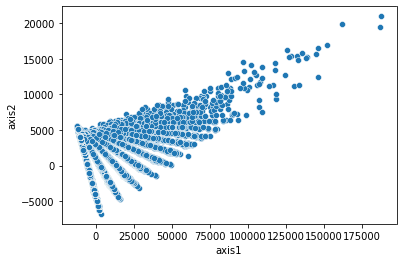

In [319]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = runner_data.drop(columns=['runner_id','gender','nationality'])
print(df.columns)



cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
sns.scatterplot(x = "axis1", y = "axis2",data = X)
plt.savefig('test1.pdf')


In [320]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
X = pd.DataFrame(
    squareform(pdist(df)),
    columns = runner_data.race_year_id,
    index = runner_data.race_year_id
)

MemoryError: Unable to allocate 15.4 GiB for an array with shape (2060338528,) and data type float64

### Regression tree

In [7]:
runner_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64193 entries, 0 to 64192
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   runner_id             64193 non-null  object 
 1   age                   64193 non-null  float64
 2   gender                64193 non-null  object 
 3   nationality           64193 non-null  object 
 4   n_races               64193 non-null  float64
 5   avg_relative_rank     64193 non-null  float64
 6   avg_rank              64193 non-null  float64
 7   max_relative_rank     64193 non-null  float64
 8   min_relative_rank     64193 non-null  float64
 9   total_elevation       64193 non-null  float64
 10  avg_elevation         64193 non-null  float64
 11  total_distance        64193 non-null  float64
 12  avg_distance          64193 non-null  float64
 13  min_distance          64193 non-null  float64
 14  max_distance          64193 non-null  float64
 15  total_eq_distance  

In [ ]:
X_tree = runner_datadata.iloc[:, :-1]
y_tree = runner_data.iloc[:, -1]